In [10]:
import cv2
import glob
import numpy as np
import os
import matplotlib.pyplot as plt
import seaborn as sns

import torch
import torch.nn as nn
from torch import optim
import torchvision.datasets
from torchvision import transforms

In [2]:
data_dir = '../data/gray_formatted/'
batch_size = 16
n_workers = 4
n_epochs = 500
lr = 0.001
img_dim = 64
display_delay = 500

# Model params
ds_kernels = [7, 3, 3, 3, 3]
ds_filters = [32, 64, 64, 128, 128]

n_res_blocks = 6
res_kernel = 3
res_filter = ds_filters[-1]

us_kernels = [3, 3, 3, 3, 7]
us_filters = [64, 64, 32, 32, 1]

In [3]:
def input_transform(img):
    img = np.array(img)[:, :, 0]
    target, outline = np.split(img, 2, axis=1)
    target = transforms.ToTensor()(target)
    outline = transforms.ToTensor()(outline)
    return outline, target

In [7]:
dataloaders = {k: torch.utils.data.DataLoader(v, batch_size=batch_size,
    shuffle=True, num_workers=0)
    for k, v in datasets.items()}

In [24]:
# We can use an image folder dataset the way we have it setup.
# Create the dataset
datasets = {k: torchvision.datasets.ImageFolder(
    root=os.path.join(data_dir, k), transform=input_transform) \
    for k in os.listdir(data_dir)}

# Create the dataloader
dataloaders = {k: torch.utils.data.DataLoader(v, batch_size=batch_size,
    shuffle=True, num_workers=0)
    for k, v in datasets.items()}

def get_generator(partition):
    for (X, y), _ in dataloaders[partition]:
        yield X, y

# Decide which device we want to run on
device = torch.device("cuda:0" if (torch.cuda.is_available()) else "cpu")

In [25]:
class CNN(nn.Module):
    def __init__(self):
        super(CNN, self).__init__()

        # 1 x 64 x 64 input
        self.in_filters = 1

        ### Downscale ###

        self.ds1 = nn.Sequential(
            nn.Conv2d(self.in_filters, ds_filters[0], kernel_size=ds_kernels[0],
                      stride=1, padding=(ds_kernels[0]-1)//2),
            nn.BatchNorm2d(ds_filters[0]),
            nn.ReLU(),
            nn.Dropout(0.4))
        self.ds2 = nn.Sequential(
            nn.Conv2d(ds_filters[0], ds_filters[1], kernel_size=ds_kernels[1],
                      stride=2, padding=(ds_kernels[1]-1)//2),
            nn.Conv2d(ds_filters[1], ds_filters[2], kernel_size=ds_kernels[2],
                      stride=1, padding=(ds_kernels[2]-1)//2),
            nn.BatchNorm2d(ds_filters[2]),
            nn.ReLU())
        self.ds3 = nn.Sequential(
            nn.Conv2d(ds_filters[2], ds_filters[3], kernel_size=ds_kernels[3],
                      stride=2, padding=(ds_kernels[3]-1)//2),
            nn.Conv2d(ds_filters[3], ds_filters[4], kernel_size=ds_kernels[4],
                      stride=1, padding=(ds_kernels[4]-1)//2),
            nn.BatchNorm2d(ds_filters[4]),
            nn.ReLU(),
            nn.Dropout(0.4))
        
        ### Residual blocks ###

        self.res_blocks = []
        for _ in range(n_res_blocks):
            res_block = nn.Sequential(
                nn.Conv2d(res_filter, res_filter, kernel_size=res_kernel,
                          stride=1, padding=(res_kernel-1)//2),
                nn.BatchNorm2d(res_filter),
                nn.ReLU(),
                nn.Conv2d(res_filter, res_filter, kernel_size=res_kernel,
                          stride=1, padding=(res_kernel-1)//2),
                nn.Dropout(0.2))

            self.res_blocks.append(res_block)
            
        ### Upscale ###
            
        self.us1 = nn.Sequential(
            nn.Conv2d(res_filter, us_filters[0], kernel_size=us_kernels[0],
                      stride=1, padding=(us_kernels[0]-1)//2),
            nn.Upsample(scale_factor=2),
            nn.Conv2d(us_filters[0], us_filters[1], kernel_size=us_kernels[1],
                      stride=1, padding=(us_kernels[1]-1)//2),
            nn.BatchNorm2d(us_filters[1]),
            nn.ReLU())
        self.us2 = nn.Sequential(
            nn.Conv2d(us_filters[1], us_filters[2], kernel_size=us_kernels[2],
                      stride=1, padding=(us_kernels[2]-1)//2),
            nn.Upsample(scale_factor=2),
            nn.Conv2d(us_filters[2], us_filters[3], kernel_size=us_kernels[3],
                      stride=1, padding=(us_kernels[3]-1)//2),
            nn.BatchNorm2d(us_filters[3]),
            nn.ReLU())
        self.us3 = nn.Conv2d(us_filters[3], us_filters[4], kernel_size=us_kernels[4],
            stride=1, padding=(us_kernels[4]-1)//2)
        
    def forward(self, x):
        z1 = self.ds1(x)
        z2 = self.ds2(z1)
        z3 = self.ds3(z2)
        
        z = z3
        for i in range(len(self.res_blocks)):
            res_output = self.res_blocks[i](z)
            z = z + res_output
        
        z4 = self.us1(z)
        z5 = self.us2(z4)
        raw = self.us3(z5)
        out = torch.clamp(raw, 0, 1)
    
        return out

    def to(self, *args, **kwargs):
        self = super().to(*args, **kwargs)
        for res_block in self.res_blocks:
            res_block = res_block.to(*args, **kwargs) 
        return self

def calc_loss(y_pred, y):
    loss = (y_pred - y)**2
    loss = loss.view(-1)
    loss = torch.sum(loss)
    
    return loss

In [26]:
def gen_imgs(model, data, temp_set_eval=True):
    if temp_set_eval:
        model.eval()

    X, y = data
    example_imgs = []
    
    for i in range(batch_size):
        outline = X[i].squeeze().detach().numpy()
        img = model(X[i:i+1].to(device)).detach().squeeze().cpu().numpy()
        actual = y[i].squeeze().detach().numpy()

        example_imgs.append(outline)
        example_imgs.append(img)
        example_imgs.append(actual)

    if temp_set_eval:
        model.train()

    return example_imgs

In [ ]:
model = CNN().to(device)
model.train()
optimizer = torch.optim.Adam(model.parameters(), lr=lr)
epoch_losses = {'train': [], 'test': []}
img_hist = []

for epoch in range(n_epochs):
    print(f'----- Epoch #{epoch+1} -----')
    
    for partition in ('train', 'test'):
        data_gen = get_generator(partition)
        
        if partition == 'test':
            img_hist.append(gen_imgs(model, next(data_gen)))
            
        epoch_loss = 0
        for step, (X, y) in enumerate(data_gen):
            X = X.to(device)
            y = y.to(device)

            if partition == 'train':
                optimizer.zero_grad()

            y_pred = model(X)
            loss = calc_loss(y_pred, y)
            epoch_loss += loss.detach().cpu().numpy() / len(X)

            if partition == 'train':
                loss.backward()
                optimizer.step()

        epoch_losses[partition].append(epoch_loss / (step + 1))

    train_loss = '{:.2f}'.format(epoch_losses['train'][-1])
    test_loss = '{:.2f}'.format(epoch_losses['test'][-1])
    print(f'train loss: {train_loss} | test loss: {test_loss}')

----- Epoch #1 -----


In [8]:
torch.save(model.state_dict(), '../models/resnet_v1.pt')

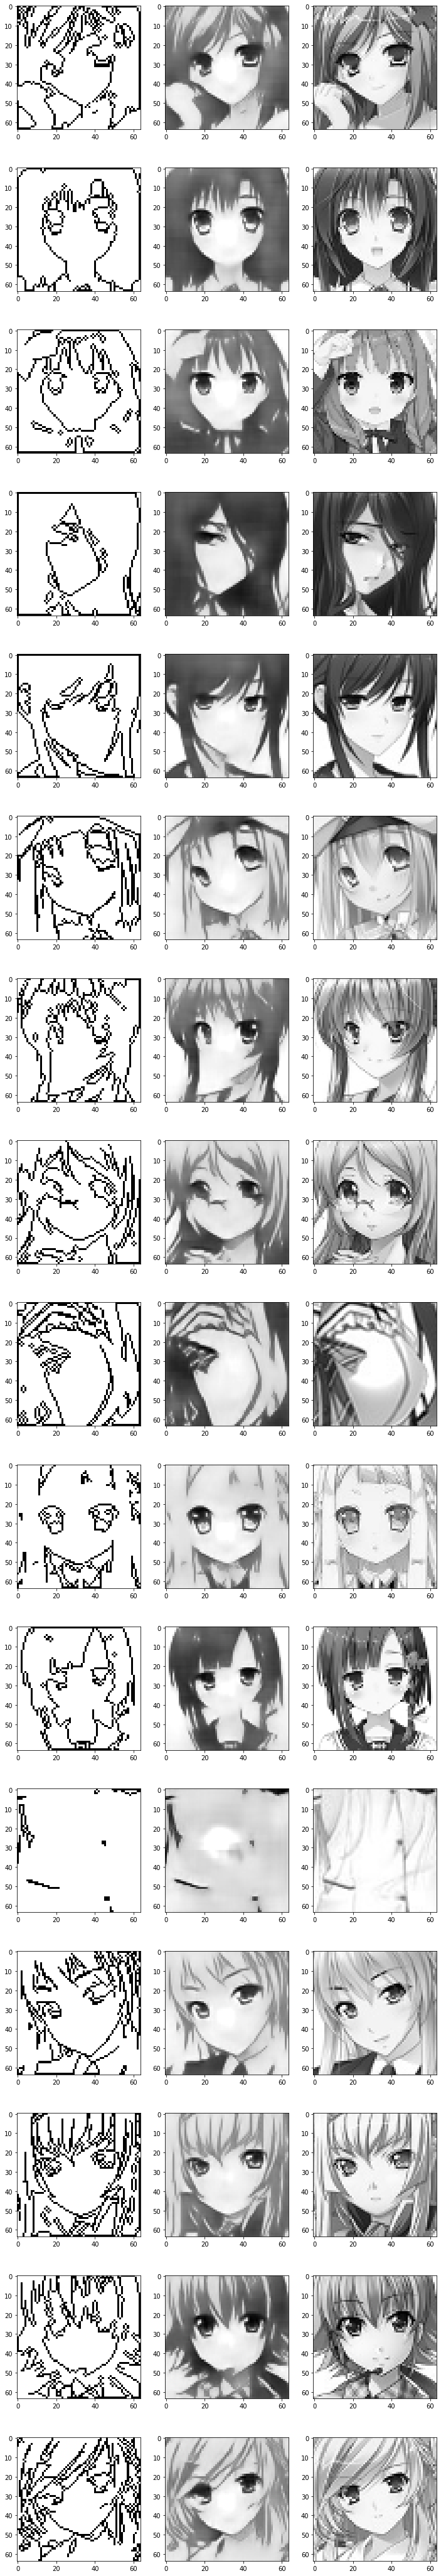

In [9]:
data_gen = get_generator()
example_imgs = gen_imgs(model, next(data_gen))

plt.figure(figsize=(12, batch_size * 5))
columns = 3
for i, img in enumerate(example_imgs):
    plt.subplot(len(example_imgs) / columns + 1, columns, i + 1)
    plt.imshow(img, cmap='gray')

In [10]:
hand_drawn = []
for img_path in glob.glob('../data/handdrawn/*.png'):
    img = cv2.imread(img_path)
    img = torch.tensor(img[:, :, 0].permute(2, 0, 1))
    
data = torch.stack(hand_drawn)
    
example_imgs = gen_imgs(model, next(data_gen))

plt.figure(figsize=(8, batch_size * 5))
columns = 2
for i, img in enumerate(example_imgs):
    plt.subplot(len(example_imgs) / columns + 1, columns, i + 1)
    plt.imshow(img, cmap='gray')

AttributeError: 'numpy.ndarray' object has no attribute 'permute'

In [11]:
hand_drawn = []
for img_path in glob.glob('../data/handdrawn/*.png'):
    img = np.float32(cv2.imread(img_path)) / 255.
    img = torch.tensor(img[:, :, :1]).permute((2, 0, 1))
    img = img.to(device)
    hand_drawn.append(img)

hd_data = torch.stack(hand_drawn)
hd_out = model(hd_data).detach().numpy()

all_imgs = []
for img1, img2 in zip(hd_data, hd_out):
    all_imgs.append(img1.squeeze().detach().numpy())
    all_imgs.append(img2.squeeze())
    
plt.figure(figsize=(8, len(all_imgs) * 5 / 2))
columns = 2
for i, img in enumerate(all_imgs):
    plt.subplot(len(all_imgs) / columns + 1, columns, i + 1)
    plt.imshow(img, cmap='gray')

TypeError: can't convert cuda:0 device type tensor to numpy. Use Tensor.cpu() to copy the tensor to host memory first.